Yang Yu (yy5bm@virginia.edu) DS 5001 Spring 2023

# Purpose

Create Topic model from DOCS

# Setup

## Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px
import nltk

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Config

In [3]:
ngram_range = [1,2]
n_terms = 4000
n_topics = 9
# n_topics = 20
max_iter = 20
n_top_terms = 9

customize

In [4]:
colors = "YlGnBu"

data_in = '/Users/yangyu/Desktop'
data_prefix = 'DS5001'

BAG = ['doc_id']

should import TOKENS

In [5]:
#DOCS = pd.read_pickle(f'{data_in}/{data_prefix}/patents.pickle')
#DOCS = DOCS[DOCS['year_y'] == 1997]
#DOCS = DOCS.drop('year_y', axis = 1)
#DOCS.columns = ['doc_str']

# Prepare data

## Create DOCS from TOKENS

In [6]:
TOKENS = pd.read_pickle(f'{data_in}/{data_prefix}/Output/TOKENS.pickle')

DOCS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

## Filter for Nouns

In [7]:
def f(text):
    global sw
    new_text = ' '.join([word for word in text.split() if word not in sw])
    return new_text


In [8]:
sw = nltk.corpus.stopwords.words('english')+[' ']+['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']\
+['fig','figure','figures','description','definition','detailed']

In [9]:
DOCS['doc_str'] = DOCS.apply(lambda x: f(x['doc_str']), axis = 1)

## Create Vector Space

In [10]:
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names_out()

In [11]:
VOCAB = pd.DataFrame(index=TERMS)
VOCAB.index.name = 'term_str'

In [12]:
DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)

In [13]:
VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
DOCS['term_count'] = DTM.sum(1)

# Generate Model

In [14]:
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

## Topic names

In [15]:
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

## Theta

In [16]:
lda_model = lda_engine.fit_transform(count_model)

In [17]:
THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES


In [18]:
THETA.sample(20).style.background_gradient(cmap=colors, axis=None)

,T0,T1,T2,T3,T4,T5,T6,T7,T8
doc_id,,,,,,,,,
5653592,0.000272,0.108163,0.140257,0.000273,0.087154,0.000273,0.613074,0.000272,0.050262
5625578,0.000102,0.000102,0.107375,0.000102,0.000102,0.129073,0.187169,0.575872,0.000102
5623579,0.000229,0.000229,0.000229,0.011082,0.009116,0.000229,0.543210,0.000229,0.435449
5701482,0.145091,0.438619,0.192363,0.208740,0.001887,0.000156,0.000156,0.000156,0.012831
5659666,0.000104,0.379021,0.079801,0.005260,0.023906,0.103936,0.121028,0.000104,0.286839
5629986,0.015948,0.033370,0.106671,0.186591,0.000121,0.000121,0.502292,0.154765,0.000121
5630156,0.221693,0.036908,0.186936,0.385852,0.000146,0.000146,0.000146,0.013508,0.154664
5685270,0.011145,0.000226,0.000226,0.058769,0.000226,0.115497,0.813457,0.000226,0.000226
5649061,0.000045,0.137538,0.000045,0.116442,0.000045,0.007551,0.593437,0.000045,0.144853


## Phi

In [19]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

In [20]:
PHI.T.sample(20).style.background_gradient(cmap=colors, axis=None)

topic_id,T0,T1,T2,T3,T4,T5,T6,T7,T8
term_str,,,,,,,,,
template pixel,0.111111,0.111111,0.111111,0.111111,0.111111,0.111113,0.111112,0.111112,80.111108
boundaries,28.293649,28.968297,15.729596,12.347157,1.815476,124.649804,54.961663,37.123157,0.111201
rl,0.111118,0.115616,18.153741,48.093052,0.111114,13.081762,0.111157,0.111240,0.111201
stem,0.111111,0.121769,0.111119,0.111140,360.639907,53.571392,0.111221,0.111210,0.111130
manufacturing,0.111125,237.406021,12.126073,0.111152,2.701725,0.111125,64.464242,0.111184,21.857352
predictions,0.111133,100.719937,0.111123,0.111124,4.072564,0.111147,232.112501,13.539328,0.111142
motor,0.111119,0.111170,37.471940,51.362767,67.242111,0.111136,363.367476,0.111140,0.111140
sake,0.111138,14.625353,0.111261,45.502308,0.111172,12.636278,7.885723,20.407162,8.609606
th sub,0.111126,0.111118,0.111155,0.111120,0.111113,0.114508,0.111204,79.107506,0.111149


# Inspect Results
## Create TOPICS and get Top Terms per Topic

In [21]:
TOPICS = PHI.stack().to_frame('topic_weight').groupby('topic_id')\
    .apply(lambda x: x.sort_values('topic_weight', ascending=False)\
        .head(n_top_terms).reset_index().drop('topic_id', axis=1)['term_str'])


In [22]:
TOPICS

term_str,0,1,2,3,4,5,6,7,8
topic_id,,,,,,,,,
T0,data,engine,bit,association,instruction,register,association engine,bits,input
T1,data,step,user,information,example,test,block,invention,time
T2,circuit,bus,voltage,output,input,channel,power,gate,cell
T3,output,data,signal,input,value,memory,control,circuit,signals
T4,cells,cell,sequence,example,dna,protein,type,acid,amino
T5,sub,vector,step,value,word,speech,number,vectors,input
T6,sub,time,value,model,control,invention,data,values,sensor
T7,sub,sub sub,sup,line,sub sup,equ,sup sub,equation,delta
T8,network,image,data,layer,input,output,neuron,training,neurons


In [23]:
TOPICS['label'] = TOPICS.apply(lambda x: x.name + ' ' + ', '.join(x[:n_top_terms]), 1)

In [36]:
labels  = TOPICS.label.tolist()

<Figure size 640x480 with 0 Axes>

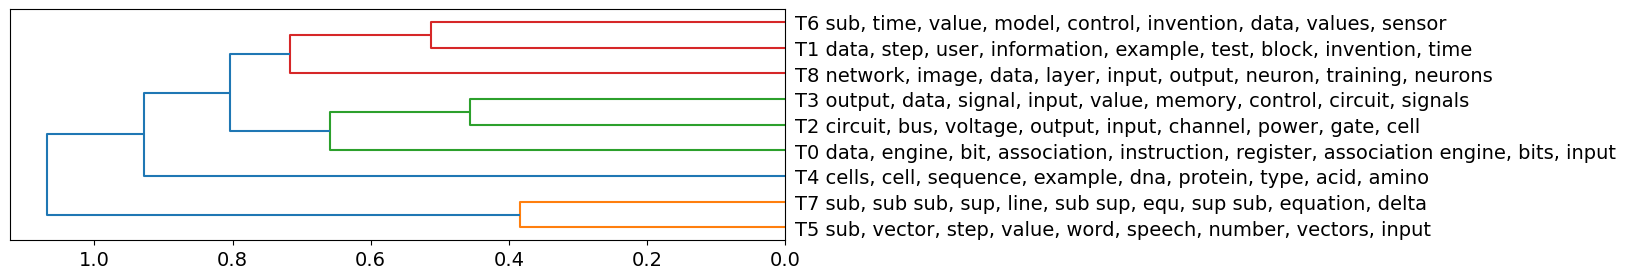

In [45]:
import plotly.figure_factory as ff
from plotly.figure_factory import create_dendrogram # Built on top SciPy

import sys
sys.path.append("/Users/yangyu/Desktop/DS5001/lib")

from hac import HAC

HAC(PHI, labels=labels).plot();

<Figure size 640x480 with 0 Axes>

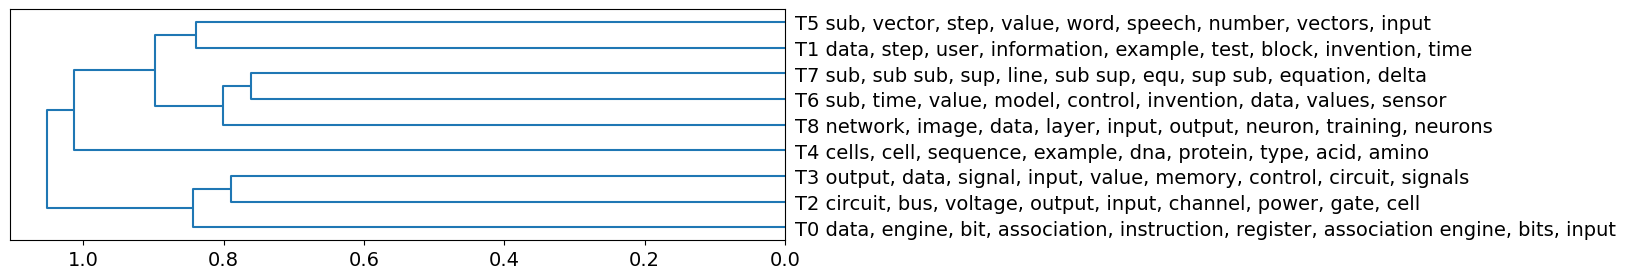

In [48]:
HAC(THETA.drop('class',axis = 1).T, labels=labels).plot()

## Compare with true label

In [26]:
cpc = pd.read_csv(f"{data_in}/{data_prefix}/g_cpc_current.tsv", sep='\t')

In [27]:
cpc = cpc.drop_duplicates(subset = ['patent_id'], keep = 'first')

In [28]:
THETA['class'] = THETA.idxmax(axis=1)

THETA.index = THETA.index.astype('int')

In [29]:
compare = pd.merge(THETA[['class']], cpc, left_on = 'doc_id', right_on = 'patent_id', how = 'left')

In [30]:
compare.groupby('cpc_section')['class'].value_counts().unstack()

class,T0,T1,T2,T3,T4,T5,T6,T7,T8
cpc_section,,,,,,,,,
A,NaN,8.0,3.0,1.0,20.0,NaN,34.0,1.0,3.0
B,NaN,1.0,NaN,1.0,1.0,NaN,13.0,4.0,NaN
C,NaN,NaN,NaN,NaN,15.0,NaN,5.0,3.0,NaN
D,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN
E,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
F,NaN,3.0,NaN,3.0,NaN,NaN,13.0,NaN,NaN
G,11.0,131.0,51.0,56.0,8.0,119.0,120.0,55.0,58.0
H,1.0,24.0,23.0,16.0,NaN,8.0,23.0,9.0,5.0
Y,NaN,17.0,1.0,10.0,4.0,3.0,8.0,1.0,4.0


# Save

In [32]:
path = '/Users/yangyu/Desktop/DS5001/output'

THETA.to_pickle(path + '/THETA.pickle')
PHI.to_pickle(path + '/PHI.pickle')
THETA.to_csv(path + '/THETA.csv')
PHI.to_csv(path + '/PHI.csv')

In [33]:
PHI

term_str,aapi,ab,ability,abs,absence,absolute,absorption,ac,acad,acad sci,...,year,years,yes,yield,yields,york,zeta,zeta sub,zeta sup,zone
topic_id,,,,,,,,,,,,,,,,,,,,,
T0,0.111111,0.111126,5.325617,0.111182,0.111182,14.999513,0.111120,0.111119,0.111111,0.111111,...,0.111141,0.111151,0.111133,0.111299,1.270611,0.111157,0.111111,0.111111,0.111111,0.111120
T1,0.111886,33.768548,190.875725,0.111142,32.496844,0.111157,0.111183,85.788163,0.111140,0.111141,...,17.423320,32.793750,107.154204,0.111281,20.768534,11.957037,0.111114,0.111115,0.111111,5.403987
T2,0.111111,12.640457,29.937044,31.164803,0.111337,0.111214,0.111136,8.191387,0.111113,0.111113,...,0.111291,0.111177,0.111272,0.111117,0.111182,0.111125,0.111112,0.111111,0.111111,25.718341
T3,0.111131,0.111149,0.111181,0.111146,14.325267,54.869495,0.111129,0.111152,0.111112,0.111111,...,0.111154,0.111122,12.220316,1.087440,0.111218,0.111139,0.111123,0.111127,0.111113,0.111185
T4,82.110302,47.040607,93.330885,0.111558,103.597192,6.369369,0.111189,45.583335,78.111006,75.111003,...,35.014251,33.839929,7.862889,22.092358,6.633989,51.453153,0.111118,0.111118,0.111111,16.568184
T5,0.111111,0.111240,30.077914,4.800054,6.234731,14.835315,0.111118,0.111122,0.111115,0.111115,...,0.111133,0.111187,17.182160,4.032945,50.112991,21.153715,3.933041,0.111135,0.111133,0.111124
T6,0.111111,13.018635,137.034862,14.855063,31.913596,55.804755,155.629778,41.002865,0.111149,0.111150,...,55.895438,47.757390,1.140643,6.364165,73.010635,47.880336,0.111189,0.111150,0.111187,336.950445
T7,0.111111,24.156939,7.195588,26.303150,8.890742,4.967020,0.111152,0.111167,0.111136,0.111137,...,0.111157,6.053095,1.106165,47.951510,30.869507,0.111192,311.101024,111.111004,103.334875,20.914464
T8,0.111126,7.041299,0.111185,0.431903,6.319108,3.932162,3.592194,1.989690,0.111119,0.111119,...,0.111114,0.111198,0.111217,19.137886,0.111333,0.111145,4.299167,0.111130,0.887248,0.111151
